In [3]:
import pandas as pd 
import numpy as np 
from simulation import simulation_erlang as sim
from preprocessing import preprocess as sched_prep
from optimization.optimization import pylice_opt_model_hard, optimize_hard
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import datetime as dt
import streamlit as st 
import seaborn as sns
from io import BytesIO 
from matplotlib.patches import Patch

In [4]:
def optimization_preprocess(n_weeks, earliest_shift,latest_shift, allowed_lens, minimum_night, minimum_day, demand, f):
    allowed_lens = set(list(map(int, allowed_lens)))
    ts = sched_prep.horizon_timestamps(n_weeks,f)
    possible_shifts, starts_ends = sched_prep.create_possible_shifs(ts, sched_prep.create_forbidden_shifts(earliest_shift,latest_shift, f),allowed_lens, f)
    shifts_info = sched_prep.compute_shift_statistics(possible_shifts, f)
    shifts_info["Start_end"] = starts_ends
    possible_shifts = sched_prep.change_column_names(possible_shifts,ts,f)
    min_demand = sched_prep.create_min_demand(ts, minimum_night, minimum_day, f)
    shift_costs = shifts_info["cost"].copy(deep = True)
    shift_costs = shift_costs.to_dict()
    S = possible_shifts.index.tolist()
    ts = possible_shifts.columns.tolist()
    demand.index = ts
    min_demand.index = ts
    demand = pd.concat([demand, min_demand]).groupby(level=0).max().sort_index().to_dict()["Staffing_level"]
    shift_day_match_start, shift_day_match_end = sched_prep.match_starting_ending(ts, shifts_info)
    day_shift_match = sched_prep.create_coverage(possible_shifts)
    return ts, S, demand, shift_costs,day_shift_match, shift_day_match_start, shift_day_match_end, possible_shifts, shifts_info


def tabularize_results(model, shift_stats, ts_horizon, overlap, shift_lenghts, f):
    choosen = []
    for i in model.ShiftSelect:
        choosen.append((i,pyo.value(model.ShiftSelect[i]) , pyo.value(model.Allocated_Teams[i])))
    choosen = pd.DataFrame(choosen).rename(columns = {1 : "selected", 2 : "staff"})
    # print(choosen)
    choosen = choosen.loc[(choosen["selected"] > 0) & (choosen["staff"] > 0)].set_index(0, drop = True).drop(columns= "selected", axis = 1)
    choosen["start_num"] = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][0], choosen.index.tolist()))
    new_end = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][1] +1 , choosen.index.tolist()))
    for n, i in enumerate(new_end):
        if i == len(ts_horizon):
            new_end[n] = 0
    choosen["end_num"] = new_end
    choosen["start"] = choosen["start_num"].apply(lambda x: shift_page.from_num_to_date(x, f))
    choosen["end"] = choosen["end_num"].apply(lambda x :shift_page.from_num_to_date(x, f))
    choosen["len"] = (choosen["end"] - choosen["start"]).dt.seconds/(60*f)
    choosen = choosen[["staff", "start_num", "end_num", "len", "start", "end"]]
    choosen.sort_values("start_num", inplace = True)
    target = dt.timedelta(minutes = overlap)
    max_allowed_len = max(shift_lenghts)
    ##
    # shifts = shift_page.create_overlap(choosen, target, max_allowed_len)
    shifts = list(map(list, choosen.reset_index().to_numpy()))
    shifts = pd.DataFrame(shifts)
    ##
    shifts.columns = choosen.reset_index(names= ["Shift_name"]).columns
    shifts.drop("len", axis = 1, inplace = True)
    shifts.set_index("Shift_name", inplace = True)
    shifts["start-end"] = shifts["start"].dt.time.astype(str) +  " - " + shifts["end"].dt.time.astype(str)

    layover = shifts[shifts["start_num"] > shifts["end_num"]].index.tolist()
    for ind in layover:
        shifts.loc[f"{ind}-->"] =   shifts.loc[ind, "staff"],\
                                    shifts.loc[ind, "start_num"],\
                                    0,\
                                    shifts.loc[ind, "start"],\
                                    pd.to_datetime("2023-01-01 00:00:00"),\
                                    shifts.loc[ind, "start-end"]
        
        shifts.loc[f"-->{ind}"] =   shifts.loc[ind, "staff"],\
                                    0,\
                                    shifts.loc[ind, "end_num"],\
                                    pd.to_datetime("2023-01-01 00:00:00"),\
                                    shifts.loc[ind, "end"],\
                                    shifts.loc[ind, "start-end"]
        shifts.drop(ind, inplace = True)

    shifts["len"] = (shifts["end"] - shifts["start"]).dt.seconds/(60*15)
    coverage = shifts[["staff", "start", "end"]].copy()
    ts_ = list(pd.date_range(start = "2023-01-01 00:00:00", end= "2023-01-08 00:00:00", freq = "15min"))
    shifts["start_num"] = shifts["start"].apply(lambda x: (ts_.index(x)))
    shifts.drop(["start", "end"], axis = 1, inplace = True)
    layover = shifts.loc[shifts["len"] < 0].index.tolist()
    for i in layover:
        shifts.loc[i, "len"] = len(ts_) - shifts.loc[i, "start_num"] ###
    shifts['color'] = shifts.apply(lambda df: shift_color(df), axis=1)
    shifts.reset_index(names = ["Shift_name"], drop = False, inplace= True)
    shifts.sort_values("start-end", inplace = True, ascending= False)
    print(f"Maximum shift length is respected: {(shifts.len > 4* max_allowed_len).unique().tolist() == [False]}")
    shifts["end_num"] = shifts["start_num"] + shifts["len"] 
    return shifts, coverage



def hour_to_string(hour):
    return str(hour).zfill(2) + ":00"

st.cache_data()
def get_day_periods():
    hour_dict = {}
    for hour in range(0,24):
        hour_dict[hour_to_string(hour)] = hour
    return hour_dict

st.cache_data()
def shift_color(row):
    c_dict = {'day':'#E64646', 'night':'#E69646', "evening" : "green"}
    timings = (["night"] * 6) + (["day"] * 9) + (["evening"] * 5) + (["night"] * 5) 
    shift_color.c_dict = c_dict
    return c_dict[timings[row['start_num']%24]]

st.cache_data()
def from_num_to_date(num,f):
    hours = str(((f*num)//60)%24).zfill(2)
    minutes = str(f*num%60).zfill(2)
    days = str(num//(24*60//f) +1 ).zfill(2)
    return pd.to_datetime(f"2023-01-{days} {hours}:{minutes}:00")

st.cache_data()
def create_overlap(shifts, target, limit):
    shifts_ = list(map(list, shifts.reset_index().to_numpy()))
    # print(shifts_)
    N = len(shifts_)
    for n in range(N):
        c_end = shifts_[n][6]
        c_len = shifts_[n][4]
        if n +1 == N:
            n_start = shifts_[0][5]
            n_len = shifts_[0][4]
        else:
            n_start = shifts_[n + 1][5]
            n_len = shifts_[n + 1][4]
        if (n_start - c_end).seconds >= target.seconds:
            continue
        if c_len == n_len:
            shifts_[n][6] = c_end + (target/3)*2
            if n +1 == N:
                shifts_[0][5] = n_start - (target/3)
            else:
                shifts_[n + 1][5] = n_start - (target/3)

        elif c_len < n_len:
            shifts_[n][6] = c_end + target

        elif c_len > n_len:
            if n +1 == N:
                shifts_[0][5] = n_start - target
            else:
                shifts_[n + 1][5] = n_start - target
    new = pd.DataFrame(shifts_)
    # print(shifts_)
    return new

st.cache_data()
def tabularize_results(model, shift_stats, ts_horizon, overlap, shift_lenghts, f):
    choosen = []
    for i in model.ShiftSelect:
        choosen.append((i,pyo.value(model.ShiftSelect[i]) , pyo.value(model.Allocated_Teams[i])))
    choosen = pd.DataFrame(choosen).rename(columns = {1 : "selected", 2 : "staff"})
    choosen = choosen.loc[(choosen["selected"] > 0) & (choosen["staff"] > 0)].set_index(0, drop = True).drop(columns= "selected", axis = 1)
    choosen["start_num"] = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][0], choosen.index.tolist()))
    new_end = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][1] + 1, choosen.index.tolist()))
    for n, i in enumerate(new_end):
        if i == len(ts_horizon):
            new_end[n] = 0
    choosen["end_num"] = new_end
    choosen["start"] = choosen["start_num"].apply(lambda x: from_num_to_date(x, f))
    choosen["end"] = choosen["end_num"].apply(lambda x :from_num_to_date(x, f))
    choosen["len"] = (choosen["end"] - choosen["start"]).dt.seconds/(60*f)
    choosen = choosen[["staff", "start_num", "end_num", "len", "start", "end"]]
    choosen.sort_values("start_num", inplace = True)
    target = dt.timedelta(minutes = overlap)
    max_allowed_len = max(shift_lenghts)
    shifts = create_overlap(choosen, target, max_allowed_len)
    # shifts = list(map(list, choosen.reset_index().to_numpy()))
    # shifts = pd.DataFrame(shifts)
    shifts.columns = choosen.reset_index(names= ["Shift_name"]).columns
    shifts.drop("len", axis = 1, inplace = True)
    shifts.set_index("Shift_name", inplace = True)
    shifts["start-end"] = shifts["start"].dt.time.astype(str) +  " - " + shifts["end"].dt.time.astype(str)

    layover = shifts[shifts["start_num"] > shifts["end_num"]].index.tolist()
    for ind in layover:
        shifts.loc[f"{ind}-->"] =   shifts.loc[ind, "staff"],\
                                    shifts.loc[ind, "start_num"],\
                                    0,\
                                    shifts.loc[ind, "start"],\
                                    pd.to_datetime("2023-01-01 00:00:00"),\
                                    shifts.loc[ind, "start-end"]
        
        shifts.loc[f"-->{ind}"] =   shifts.loc[ind, "staff"],\
                                    0,\
                                    shifts.loc[ind, "end_num"],\
                                    pd.to_datetime("2023-01-01 00:00:00"),\
                                    shifts.loc[ind, "end"],\
                                    shifts.loc[ind, "start-end"]
        shifts.drop(ind, inplace = True)

    shifts["len"] = (shifts["end"] - shifts["start"]).dt.seconds/(60*15)
    coverage = shifts[["staff", "start", "end"]].copy()
    ts_ = list(pd.date_range(start = "2023-01-01 00:00:00", end= "2023-01-08 00:00:00", freq = "15min"))
    shifts["start_num"] = shifts["start"].apply(lambda x: (ts_.index(x)))
    shifts.drop(["start", "end"], axis = 1, inplace = True)
    layover = shifts.loc[shifts["len"] < 0].index.tolist()
    for i in layover:
        shifts.loc[i, "len"] = len(ts_) - shifts.loc[i, "start_num"] ###
    shifts['color'] = shifts.apply(lambda df: shift_color(df), axis=1)
    shifts.reset_index(names = ["Shift_name"], drop = False, inplace= True)
    shifts.sort_values("start-end", inplace = True, ascending= False)
    print(f"Maximum shift length is respected: {(shifts.len > 4* max_allowed_len).unique().tolist() == [False]}")
    shifts["end_num"] = shifts["start_num"] + shifts["len"] 
    return shifts, coverage

# st.cache_resource()
def plot_resulting_schedule(result, assigned):
    p = 60//15
    c_dict = {'day':'#E64646', 'night':'#E69646', "evening" : "green"}
    colors = {"background" : "lightgray", "shifts_colors" : c_dict, "staffing levels" : "green", "assigned levels" : "red", "vlines" : "blue"}

    fig, axs = plt.subplots(2, 1, figsize=(18,12), sharex= False)
    bars = axs[0].barh(result["start-end"], result.len, left=result.start_num, zorder = 2, color = result.color)
    y_max = 0
    y_min = 0
    for rect in bars:
        if rect.get_y() + rect.get_height() > y_max:
            y_max = rect.get_y() + rect.get_height()
        if rect.get_y() - rect.get_height() < y_min:
            y_min = rect.get_y() - rect.get_height()

    legend_elements = [Patch(facecolor= colors["shifts_colors"][i], label=i)  for i in colors["shifts_colors"]]
    axs[0].legend(handles=legend_elements, facecolor = colors["background"], framealpha=0)

    for day in range(0,(24*7*p), 24*p):
        axs[0].vlines(x = day, ymin = y_min, ymax =y_max + 0.2, color = colors["vlines"], zorder = 1, alpha = .5)
    axs[0].set_xticks(list(range(12*p,(24*7*p), 24*p)))
    axs[0].set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

    xticks_minor = list(range(24*7*p))
    axs[0].set_xticks(xticks_minor, minor=True)
    axs[0].set_ylim(ymin= y_min, ymax = y_max + 0.2)
    axs[0].set_xlim(xmin= 0, xmax = 24*7*p)
    axs[0].spines["bottom"].set_visible(False)
    axs[0].set_facecolor(colors["background"])

    axs[1].plot(assigned.index, assigned.Assigned,zorder = 2, color = colors["assigned levels"])
    axs[1].plot(assigned.index, assigned.Staffing_level,zorder = 1, color = colors["staffing levels"])
    axs[1].fill_between(assigned.index, assigned.Staffing_level, color = colors["staffing levels"], zorder = 1)
    for day in range(0,(24*7*4), 24*4):
        axs[1].vlines(x = day, ymin = 0, ymax =max(assigned.Assigned.max(), assigned.Staffing_level.max()) +0.2, color = colors["vlines"], zorder = 1, alpha = .5)
    axs[1].set_xticks(list(range(12*4,(24*7*4), 24*4)))
    xticks_minor = list(range(0 ,24*7*4,4))
    axs[1].set_xticks(xticks_minor, minor=True)
    axs[1].set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    axs[1].set_xlim(xmin= 0, xmax = 24*7*4)
    axs[1].set_ylim(ymin= 0, ymax = max(assigned.Assigned.max(), assigned.Staffing_level.max()))
    axs[1].spines['top'].set_visible(False)
    axs[1].set_facecolor(colors["background"])
    axs[1].set_ylabel("Number of employees")
    axs[1].set_xlabel("Average Week")
    # fig.patch.set_facecolor(colors["background"])
    plt.subplots_adjust(wspace=0, hspace =0)
    return fig


st.cache_resource()
def display_model_results(df, Type):
    fig = plt.figure(figsize=(12, 6))
    sns.lineplot(df["Staffing Level"].tolist())
    ticks = list(range(0,len(df.index),12))
    labs = [df.index.tolist()[x] for x in ticks]
    plt.xticks(ticks = ticks, labels = labs, rotation = 85)
    plt.xticks(ticks = range(len(df.index)), minor = True)
    plt.title(f"Staffing Level to address {Type} calls" )
    plt.ylabel("Staffing Levels per Hour")
    return fig

# st.cache_resource()
def display_combined_results(all_data):

    # fig,ax = plt.subplots(figsize=(12, 6))
    # fig = plt.figure(figsize=(12, 6))
    # plt.stackplot(all_data.index.tolist(), all_data[types[0]], all_data[types[1]], labels = types)#,color=['orange', 'skyblue'])
    fig = all_data.plot(stacked=True, color=['tomato', 'skyblue', 'green'], figsize=(12, 6), rot = 60).figure # kind='area'
    ticks = list(range(0,len(all_data.index),6))
    labs = [all_data.index.tolist()[x] for x in ticks]
    plt.xticks(ticks = ticks, labels = labs, rotation = 85)
    plt.xticks(ticks = range(len(all_data.index)), minor = True)
    plt.xlabel('Hour of the Week')
    plt.ylabel('Staffing Level')
    plt.title('Combined Staffing Levels')
    plt.legend(loc = "upper left")
    plt.ylim(bottom = 0)
    return fig

def create_horizon_dates(s_start, horizon, f):
    start_date = pd.to_datetime(s_start, format="%y-%m-%d")
    end_date = start_date + dt.timedelta(weeks= horizon, hours= 23, minutes= 59)
    return pd.date_range(start= start_date, end = end_date, freq= f"{f}min")

## Simulation - Staffing Levels

In [5]:
# Generate date range for the entire year
start_date = pd.to_datetime("2024-01-01")
end_date = pd.to_datetime("2024-12-31")
date_range = pd.date_range(start_date, end_date)

# Create DataFrame with random demand values
df = pd.DataFrame(index=date_range)
df['demand'] = np.random.randint(1, 8, size=len(date_range))
demand_df = df

In [6]:
# DEFAULT SCENARIO PARAMETERS - OK 
params = {"service_level" : [0.9],
        "shrinkage" :       [0.4],
        "max_occupancy" :   [0.8],
        "asa" :             [2],
        "aht":              [2],
        'interval':         [8]}

interval = value = params['interval']
service_level = value= params["service_level"]
asa = value = params["asa"]
aht = value = params["aht"]
shrinkage = value = params["shrinkage"]
max_occupancy = value = params["max_occupancy"]
demand = demand_df.demand


staffing_levels = sim.compute_staffing_levels(demand = demand,
                                          aht = aht,
                                          asa=asa,
                                          interval=interval,
                                          shrinkage=shrinkage,
                                          service_level=service_level,
                                          max_occupancy=max_occupancy)
staffing_levels['Month'] = staffing_levels.index.strftime('%B')

,Number of surgeries,Raw Staffing Level,Staffing Level,Service Level (%),Occupancy (%),Waiting Probability (%),Month
2024-01-01,1,2,4,99.52,12.50,2.78,January
2024-01-02,5,3,5,97.30,41.67,15.55,January
2024-01-03,5,3,5,97.30,41.67,15.55,January
2024-01-04,3,2,4,94.14,37.50,20.45,January
2024-01-05,6,3,5,94.72,50.00,23.68,January
...,...,...,...,...,...,...,...
2024-12-27,3,2,4,94.14,37.50,20.45,December
2024-12-28,4,3,5,98.77,33.33,9.09,December
2024-12-29,3,2,4,94.14,37.50,20.45,December
2024-12-30,4,3,5,98.77,33.33,9.09,December


c:\Users\Consumer\Desktop\projects\NorwegianHealthSector\HealthSector\simulation\simulation_erlang.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  staffing_levels.drop('Month',axis=1, inplace=True)


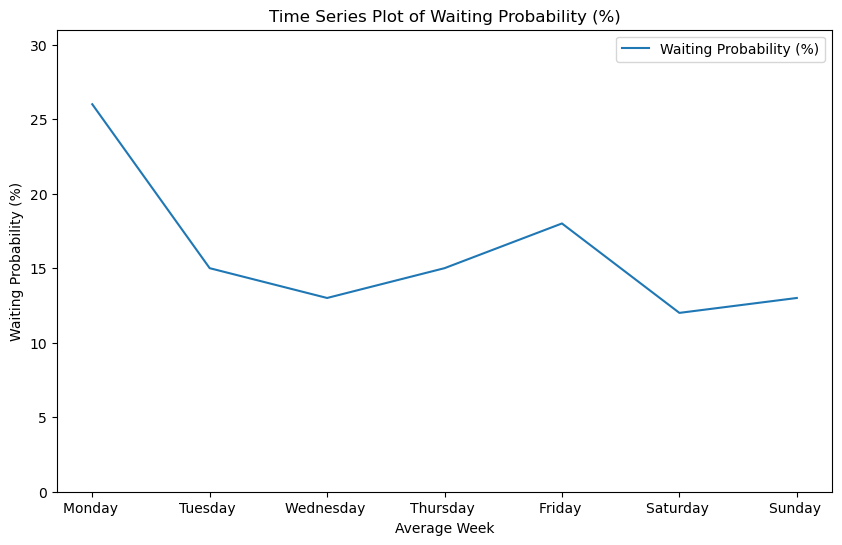

In [7]:
display(staffing_levels)
sim.create_staffing_levels_average_week_plot(staffing_levels, 'July', 'Waiting Probability (%)')

## Hard Constrained Model

In [ ]:
def run_hard(earliest, latest, shift_lenghts, minimum_night, minimum_day, demand, timeframe, teamsize, max_cap, overlap):
    ##################
    shift_lenghts = list(map(lambda x: x*(60//timeframe), shift_lenghts))
    ts_horizon, S,\
        demand, shift_costs,\
            t_s_cov, starting_shfits,\
                ending_shifts, possible_shifts,\
                    shift_stats = optimization_preprocess(n_weeks = 1,
                                                        earliest_shift = earliest,
                                                        latest_shift = latest,
                                                        allowed_lens = shift_lenghts,
                                                        minimum_night= minimum_night,
                                                        minimum_day = minimum_day,
                                                        demand = demand.copy(),
                                                        f = timeframe)

    opt_model = pylice_opt_model_hard(time_t = ts_horizon,
                                    p_shifts = S,
                                    demand = demand,
                                    teamsize = teamsize,
                                    cap_max = max_cap,
                                    shift_cost = shift_costs,
                                    day_shift_match= t_s_cov,
                                    shift_day_match_start= starting_shfits,
                                    shift_day_match_end = ending_shifts)
    opt_model, status = optimize_hard(opt_model)

    results, n_assigned = tabularize_results(opt_model, shift_stats, ts_horizon, overlap, shift_lenghts, timeframe)

    ts_ = list(create_horizon_dates("2024-01-01", 1, 60))
    n_assigned = results[["start_num", "end_num", "staff"]].astype(int).copy()
    n_assigned["coverage"] = n_assigned[["start_num", "end_num"]].apply(lambda df: ts_[df["start_num"] : df["end_num"]], axis = 1)
    n_assigned =  n_assigned.explode("coverage")
    n_assigned = n_assigned.groupby("coverage").agg({"staff":"sum"}).sort_index()
    n_assigned.rename({"staff": "Assigned"}, axis = 1, inplace = True)
    n_assigned = n_assigned.sort_index().resample("15min").ffill()

    demand = pd.DataFrame.from_dict(demand.items()).rename(columns = {0: "Date_time", 1 : "Staffing_level"})
    demand.set_index("Date_time", inplace = True)
    mapping = {"Monday" : "1", "Tuesday" : "2", "Wednesday" : "3", "Thursday" : "4", "Friday" : "5", "Saturday" : "6", "Sunday" : "7"}
    demand.index = list(map(lambda x : pd.to_datetime("2023-01-0" + mapping[x.split(" ")[0]] + " " + x.split(" ")[1]), demand.index.tolist()))
    demand = demand.sort_index().resample("15min").ffill()

    n_assigned = pd.merge(n_assigned, demand, right_index = True, left_index = True, how = "outer").ffill()
    n_assigned.reset_index(drop = False, names = ["date"], inplace = True)

    schedule_graph = plot_resulting_schedule(results.sort_values("start-end"), n_assigned)
    plt.show()
    n_assigned["OverStaffing"] = n_assigned["Assigned"] - n_assigned["Staffing_level"]
    print(f"Average overstaffing: {n_assigned.OverStaffing.mean()}")
    print(f"Maximum overcoverage: {n_assigned.OverStaffing.max()}")
    print(f"Total cost: {pyo.value(opt_model.Tot_Costs)}")
    # plot_staffing_requirements(demand, params)
    return results, n_assigned

In [15]:
earliest = 7
latest = 22
minimum_night = 3
minimum_day = 4
teamsize = 4
max_cap = 15
shift_lenghts = [5,6,7, 8]
overlap = 45
timeframe = interval

# results, final = run_hard(earliest, latest, shift_lenghts, minimum_night, minimum_day, demand, timeframe, teamsize, max_cap, overlap)

In [16]:
shift_lenghts = list(map(lambda x: x*(60//60), shift_lenghts))
shift_lenghts


[5, 6, 7, 8]